In [1]:
# Install necessary libraries
!pip install kaggle --quiet

# Upload kaggle.json for Kaggle API access
from google.colab import files
files.upload()

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the UTKFace dataset from Kaggle
!kaggle datasets download -d jangedoo/utkface-new
!unzip -q utkface-new.zip -d utkface-new

!pip install tensorflow

Saving kaggle (1).json to kaggle (1).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 329M/331M [00:15<00:00, 24.5MB/s]
100% 331M/331M [00:15<00:00, 22.5MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the dataset path
path = Path("utkface-new/UTKFace/")  # Replace with your dataset path
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
# Shuffle filenames
np.random.seed(10)
np.random.shuffle(filenames)

# Extract labels from filenames
age_labels, gender_labels, race_labels, image_path = [], [], [], []
for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

# Create DataFrame
df = pd.DataFrame({
    'image': image_path,
    'age': age_labels,
    'gender': gender_labels,
    'race': race_labels
})


In [4]:
# Remove outliers and convert data types
df = df[df['race'].isin(['0', '1', '2', '3', '4'])]
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

# Split dataset into train and test sets
train, test = train_test_split(df, train_size=0.8, random_state=42)

<ipython-input-4-8a0ebb1723ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = df['gender'].astype('int32')
<ipython-input-4-8a0ebb1723ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = df['age'].astype('int32')
<ipython-input-4-8a0ebb1723ee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [5]:
# Define preprocessing function
def preprocess_image(file_path, labels):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Resize to model input size
    image = image / 255.0  # Normalize to [0, 1]
    return image, labels

In [6]:
# Prepare the dataset
train_file_paths = [str(path / fname) for fname in train['image']]
train_labels = {
    'gender_output': train['gender'].values,
    'age_output': train['age'].values,
    'race_output': tf.keras.utils.to_categorical(train['race'], num_classes=5)
}

test_file_paths = [str(path / fname) for fname in test['image']]
test_labels = {
    'gender_output': test['gender'].values,
    'age_output': test['age'].values,
    'race_output': tf.keras.utils.to_categorical(test['race'], num_classes=5)
}


In [7]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch, shuffle, and prefetch
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Define the custom CNN model
def build_cnn(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Convolutional Block 1
    X = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)

    # Convolutional Block 2
    X = Conv2D(64, (3, 3), activation='relu', padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)

    # Convolutional Block 3
    X = Conv2D(128, (3, 3), activation='relu', padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)

    # Convolutional Block 4
    X = Conv2D(256, (3, 3), activation='relu', padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)

    # Fully Connected Layers
    X = Flatten()(X)
    X = Dense(512, activation='relu')(X)
    X = Dropout(0.5)(X)

    # Outputs
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(X)
    age_output = Dense(1, activation='linear', name='age_output')(X)
    race_output = Dense(5, activation='softmax', name='race_output')(X)

    model = Model(inputs=inputs, outputs=[gender_output, age_output, race_output])
    return model


In [9]:
# Build the model
model = build_cnn()

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mean_absolute_error',
        'race_output': 'accuracy'
    }
)


In [10]:
# Mount Google Drive to save the model
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/My Drive/vision/project/models/CNN/tAPI'
os.makedirs(save_path, exist_ok=True)

# Define a checkpoint callback
checkpoint = ModelCheckpoint(
    os.path.join(save_path, 'best_model.keras'),
    monitor='val_race_output_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

Mounted at /content/drive


Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - age_output_loss: 7.7590 - age_output_mean_absolute_error: 60.5469 - gender_output_accuracy: 0.4785 - gender_output_loss: 1430.9957 - loss: 1444.8333 - race_output_accuracy: 0.4197 - race_output_loss: 6.0796
Epoch 1: val_race_output_loss improved from inf to 1.09715, saving model to /content/drive/My Drive/vision/project/models/CNN/tAPI/best_model.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 55s 72ms/step - age_output_loss: 7.7590 - age_output_mean_absolute_error: 60.5393 - gender_output_accuracy: 0.4785 - gender_output_loss: 1431.0089 - loss: 1444.8409 - race_output_accuracy: 0.4198 - race_output_loss: 6.0743 - val_age_output_loss: 7.5898 - val_age_output_mean_absolute_error: 46.0813 - val_gender_output_accuracy: 0.4702 - val_gender_output_loss: 1436.8514 - val_loss: 1448.1616 - val_race_output_accuracy: 0.5855 - val_race_output_loss: 1.0971
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - age_output_loss: 7.6654 - age_output_mean_abso

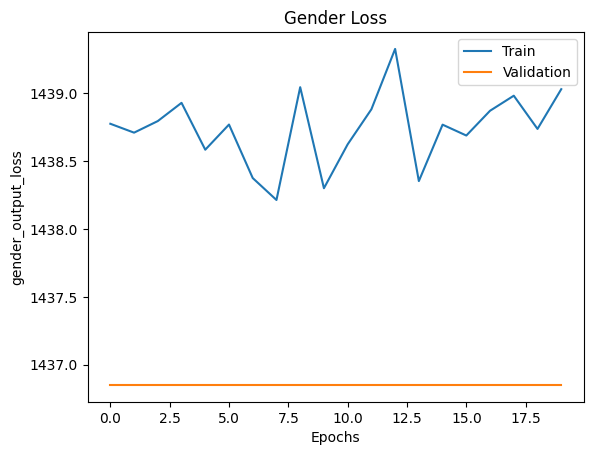

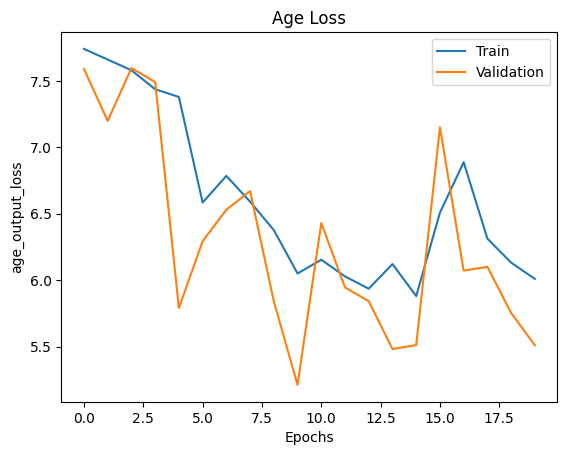

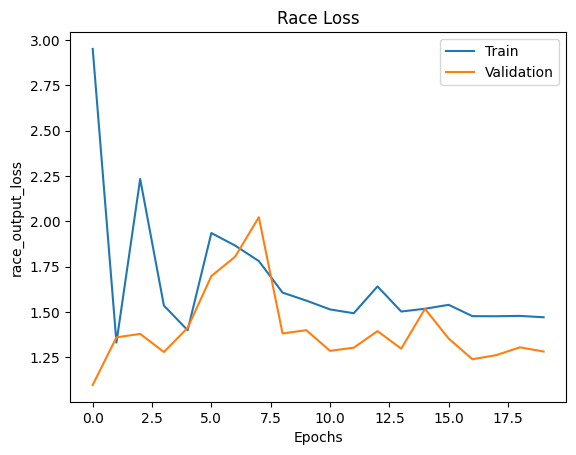

In [11]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=[checkpoint]
)

# Plot training history
def plot_metrics(history, metric_name, title):
    plt.plot(history.history[metric_name], label='Train')
    plt.plot(history.history[f'val_{metric_name}'], label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_metrics(history, 'gender_output_loss', 'Gender Loss')
plot_metrics(history, 'age_output_loss', 'Age Loss')
plot_metrics(history, 'race_output_loss', 'Race Loss')

In [12]:
# Evaluate the model
test_results = model.evaluate(
    test_dataset,
    verbose=1
)

print(f"Test results: {test_results}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - age_output_loss: 5.4669 - age_output_mean_absolute_error: 66.5319 - gender_output_accuracy: 0.4784 - gender_output_loss: 1455.3297 - loss: 1462.0975 - race_output_accuracy: 0.5170 - race_output_loss: 1.2657
Test results: [1446.2908935546875, 1436.8514404296875, 5.509757995605469, 1.2816144227981567, 66.92871856689453, 0.4701539874076843, 0.5142375230789185]
